# Amazon Customer Reviews
Springboard Data Science Career Track
Capstone 2
by Chantel Clark

## The Problem
Business owners often do not have the time to sort out their customer reviews, especially when there are thousands of online reviews. I want to develop a way to help businesses to sort their customer reviews, and find the most useful and reliable customer reviews. Businesses would be able to save time from reading every review, and gain insights and actionable goals from the most reliable reviews. This could help businesses to improve service or product quality by understanding the customer’s perspective. 

## Data
Amazon has an open dataset of over 130 million customer reviews collected between 1995 and 2015, available as URL’s at https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt. Reviews are grouped by product categories such as apparel, automotive, books, e-books, etc. The columns in the dataset include: ‘marketplace’ (country code), ‘customer_id’, ‘review_id’, ‘product_id’, ‘product_parent’ (random identifier for aggregate reviews for the same product), ‘product_title’, ‘product_category’, ‘star_rating’, ‘helpful_votes’, ‘total_votes’, ‘vine’, ‘verified_purchase’, ‘review_headline’, ‘review_body’, ‘review_date’.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from random import sample as rsample
from random import seed
import nltk
import time

In [2]:
# Import sample data from URL
url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/sample_us.tsv'

url_data = pd.read_table(url, sep='\t')
sample = pd.DataFrame(url_data, columns=url_data.keys())
print(sample.head())

  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     18778586   RDIJS7QYB6XNR  B00EDBY7X8       122952789   
1          US     24769659  R36ED1U38IELG8  B00D7JFOPC       952062646   
2          US     44331596   R1UE3RPRGCOLD  B002LHA74O       818126353   
3          US     23310293  R298788GS6I901  B00ARPLCGY       261944918   
4          US     38745832    RNX4EXOBBPN5  B00UZOPOFW       717410439   

                                       product_title product_category  \
0                         Monopoly Junior Board Game             Toys   
1  56 Pieces of Wooden Train Track Compatible wit...             Toys   
2         Super Jumbo Playing Cards by S&S Worldwide             Toys   
3           Barbie Doll and Fashions Barbie Gift Set             Toys   
4  Emazing Lights eLite Flow Glow Sticks - Spinni...             Toys   

   star_rating  helpful_votes  total_votes vine verified_purchase  \
0            5              0            0    N

In [3]:
type(sample)

pandas.core.frame.DataFrame

In [4]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 15 columns):
marketplace          49 non-null object
customer_id          49 non-null int64
review_id            49 non-null object
product_id           49 non-null object
product_parent       49 non-null int64
product_title        49 non-null object
product_category     49 non-null object
star_rating          49 non-null int64
helpful_votes        49 non-null int64
total_votes          49 non-null int64
vine                 49 non-null object
verified_purchase    49 non-null object
review_headline      49 non-null object
review_body          49 non-null object
review_date          49 non-null object
dtypes: int64(5), object(10)
memory usage: 5.9+ KB


In [5]:
# Import larger data set - Amazon apparel reviews
# Skips 'bad_lines', gets tokenization error without skipping (C error: expected 15 fields, saw 22)
url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz'

url_data = pd.read_table(url, sep='\t', error_bad_lines=False)
url_df = pd.DataFrame(url_data, columns=url_data.keys())
print(url_df.head())

b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\nSkipping line 104435: expected 15 fields, saw 22\nSkipping line 109766: expected 15 fields, saw 22\nSkipping line 124024: expected 15 fields, saw 22\nSkipping line 129914: expected 15 fields, saw 22\nSkipping line 130172: expected 15 fields, saw 22\n'
b'Skipping line 161515: expected 15 fields, saw 22\n'
b'Skipping line 230464: expected 15 fields, saw 22\n'
b'Skipping line 292640: expected 15 fields, saw 22\nSkipping line 293681: expected 15 fields, saw 22\nSkipping line 316511: expected 15 fields, saw 22\nSkipping line 317239: expected 15 fields, saw 22\nSkipping line 326099: expected 15 fields, saw 22\nSkipping line 327595: expected 15 fields, saw 22\n'
b'Skipping line 342645: expected 15 fields, saw 22\nSkipping line 347980: expected 15 fields, saw 22\nSkipping line 376258: expected 15 fields, saw 22\nSkipping line 381192: expected 

  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     32158956  R1KKOXHNI8MSXU  B01KL6O72Y        24485154   
1          US      2714559  R26SP2OPDK4HT7  B01ID3ZS5W       363128556   
2          US     12608825   RWQEDYAX373I1  B01I497BGY       811958549   
3          US     25482800  R231YI7R4GPF6J  B01HDXFZK6       692205728   
4          US      9310286  R3KO3W45DD0L1K  B01G6MBEBY       431150422   

                                       product_title product_category  \
0  Easy Tool Stainless Steel Fruit Pineapple Core...          Apparel   
1  V28 Women Cowl Neck Knit Stretchable Elasticit...          Apparel   
2  James Fiallo Men's 12-Pairs Low Cut Athletic S...          Apparel   
3  Belfry Gangster 100% Wool Stain-Resistant Crus...          Apparel   
4  JAEDEN Women's Beaded Spaghetti Straps Sexy Lo...          Apparel   

   star_rating  helpful_votes  total_votes vine verified_purchase  \
0          4.0            0.0          0.0    N

In [6]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881874 entries, 0 to 5881873
Data columns (total 15 columns):
marketplace          object
customer_id          int64
review_id            object
product_id           object
product_parent       int64
product_title        object
product_category     object
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtypes: float64(3), int64(2), object(10)
memory usage: 673.1+ MB


There are 5,881,873 reviews in this dataset.

In [7]:
# Convert 'review_date' column to datetime
url_df['review_date'] = pd.to_datetime(url_df['review_date'])

In [8]:
# Date of the oldest review
min(url_df['review_date'])

Timestamp('2000-09-06 00:00:00')

In [9]:
# Date of the newest review
max(url_df['review_date'])

Timestamp('2015-08-31 00:00:00')

In [10]:
# Some of these are not classified correctly...
print(url_df.iloc[0].product_title)
print(url_df.iloc[100].product_title)

Easy Tool Stainless Steel Fruit Pineapple Corer Slicer Peeler Cut (One size, sliver)
Amdirect Portable Parachute Outdoor Travel Camping Beach Canvas Hammock


In [11]:
url_df.iloc[100].review_body

'very comfortable, soft and easy to install, I love to sleep on it'

## Customers

In [12]:
# Create a dictionary of unique customers, with value equal to number of reviews written
customers = dict(url_df['customer_id'].value_counts())

In [13]:
# Convert dictionary to dataframe
customer_df = pd.DataFrame(customers.items(), columns=['customer_ID', 'n_reviews'])
customer_df.head()

,customer_ID,n_reviews
0,50612720,559
1,33883540,351
2,33924372,344
3,37474421,281
4,15006109,262


In [14]:
# Print the total number of unique customers
len(customer_df)

3219083

There are 3,219,083 unique customers

In [15]:
print('The mean number of reviews is', np.mean(customer_df.n_reviews))
print('The median number of reviews is', np.median(customer_df.n_reviews))

The mean number of reviews is 1.827189295833627
The median number of reviews is 1.0


The average number of reviews that a customer writes is 1.83, while the median number of reviews per customer is 1. Because the average is larger than the median, it is evident that some customers are posting a very large number of reviews which is skewing the dataset to the right (long right tail). The median number of reviews per customer is low, and could be a result of fake accounts where only one review is posted.

Text(0, 0.5, 'Number of customers')

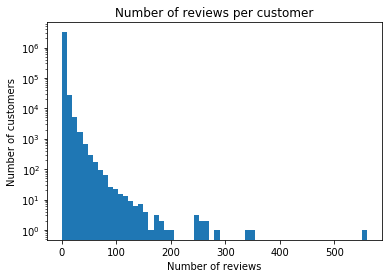

In [16]:
plt.hist(customer_df.n_reviews, bins=60, log=True)
plt.title('Number of reviews per customer')
plt.xlabel('Number of reviews')
plt.ylabel('Number of customers')

In [17]:
# Number of customers that have only posted 1 review 'one hit wonders'
print('Number of one hit wonders', len(customer_df.customer_ID[customer_df.n_reviews == 1]))

# Percentage of customers that post only one review = 68.4%!
n_customers = len(customers)
print('Percent of one hit wonders', len(customer_df.customer_ID[customer_df.n_reviews == 1])/ n_customers)

Number of one hit wonders 2201632
Percent of one hit wonders 0.6839314177360447


In [18]:
n_revs = customer_df.n_reviews
n_revs.describe()

count    3.219083e+06
mean     1.827189e+00
std      2.466301e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.590000e+02
Name: n_reviews, dtype: float64

In [19]:
# Find the skew of the data
n_revs.skew()

19.153069126538394

In [20]:
# Log transform the data
n_revs_log = np.log(n_revs)
n_revs_log.describe()

count    3.219083e+06
mean     3.445132e-01
std      5.887699e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.931472e-01
max      6.326149e+00
Name: n_reviews, dtype: float64

In [21]:
# Compare the skew to original data - skew is much lower after log tranformation
n_revs_log.skew()

1.8703245642780428

Text(0, 0.5, 'Number of customers')

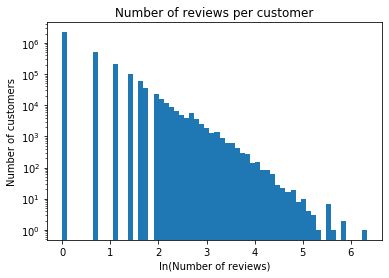

In [22]:
plt.hist(n_revs_log, bins=60, log=True)
plt.title('Number of reviews per customer')
plt.xlabel('ln(Number of reviews)')
plt.ylabel('Number of customers')

Text(0.5, 0, 'ln(n_reviews)')

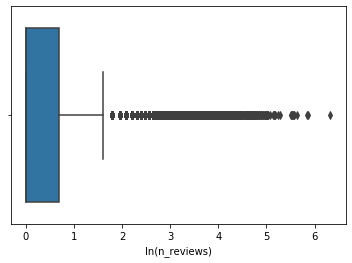

In [23]:
# Create boxplot to identify outliers
sns.boxplot(n_revs_log)
plt.xlabel('ln(n_reviews)')

In [24]:
# Calculate the interquartile range
iqr = n_revs_log.quantile(0.75) - n_revs_log.quantile(0.25)

# Find whisker length
whisker_length = 3 * iqr
upper_whisker_loc = n_revs_log.quantile(0.75) + whisker_length
print(upper_whisker_loc)

2.772588722239781


In [25]:
# Transform upper whisker length back to original scale
np.exp(upper_whisker_loc)

15.999999999999998

Customers with more than 5 reviews, considered as outlier. Does not seem right because on average, a 'real' (not fake) customer could write around 5 reviews easily. The large amount of customers that write only one review is still skewing the data. Using a whisker length of three times the IQR indicate customers with 16 or more reviews are outliers.

In [26]:
# Number of outliers
n_outliers = len(n_revs_log[n_revs_log > upper_whisker_loc])
print('outliers:', n_outliers)

outliers: 12400


In [27]:
# Percentage of outliers
n = len(n_revs_log)
n_outliers/n*100

0.3852028667791418

12,400 (0.39%) the customers have reviews that fall above 3 x IQR + 75th percentile.

In [28]:
# Remove one hit wonders (customers that only wrote one review)
customer_df2 = customer_df[customer_df.n_reviews != 1]
print(len(customer_df2))
customer_df2.tail()

1017451


,customer_ID,n_reviews
1017446,11480034,2
1017447,4111235,2
1017448,12498965,2
1017449,32152611,2
1017450,15871175,2


Text(0, 0.5, 'Number of customers')

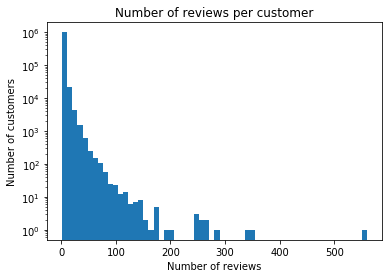

In [29]:
plt.hist(customer_df2.n_reviews, bins=60, log=True)
plt.title('Number of reviews per customer')
plt.xlabel('Number of reviews')
plt.ylabel('Number of customers')

In [30]:
# Log transform the data
n_revs_log = np.log(customer_df2.n_reviews)
n_revs_log.describe()

count    1.017451e+06
mean     1.089995e+00
std      5.330890e-01
min      6.931472e-01
25%      6.931472e-01
50%      6.931472e-01
75%      1.386294e+00
max      6.326149e+00
Name: n_reviews, dtype: float64

In [31]:
# Calculate the interquartile range
iqr = n_revs_log.quantile(0.75) - n_revs_log.quantile(0.25)

# Find whisker length
whisker_length = 1.5 * iqr
upper_whisker_loc = n_revs_log.quantile(0.75) + whisker_length
print(upper_whisker_loc)

# Transform upper whisker length back to original scale
print(np.exp(upper_whisker_loc))

2.4260151319598084
11.31370849898476


In [32]:
# Number of outliers
n_outliers = len(n_revs_log[n_revs_log > upper_whisker_loc])
print('outliers:', n_outliers)


outliers: 28683


In [33]:
# Percent of all unique customers
n_outliers/len(customer_df)

0.008910301474053325

This seems like a better threshold for determining whether or not a customer should be suspicious. If they are in the top 0.89% for number of reviews, writing more than 11 reviews could be indicative of a customer being an outlier.

## The most active reviewer

In [34]:
# Check out a sample customer with largest number of reviews - 559 reviews
cid_sample = customer_df.iloc[0].customer_ID
cid_reviews = url_df[url_df['customer_id'] == cid_sample]
cid_reviews.head()


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
5027866,US,50612720,RHNSTL5UZQQTS,B002TPMFL6,15026908,Tunic Top Cotton Kurti-brown Gold Printed Cott...,Apparel,4.0,0.0,0.0,N,N,women tunic top,Stunning Cotton Kurti with gorgeous colored pr...,2009-10-23
5064403,US,50612720,R2R5WABNC8M64U,B002ON2DB0,744097385,Fashion Blue Skirt Floral Print Fashion Clothe...,Apparel,5.0,0.0,0.0,N,N,Casual Summer Spring Women's Skirt,This classic cotton boho tier skirt are perfec...,2009-09-11
5064413,US,50612720,R2W6U4GDW9Y6GN,B002ON09KC,34396106,Skirts for Women Barmer Print Spring and Summe...,Apparel,4.0,0.0,0.0,N,N,casual summer Spring womens Skirt,This classic cotton boho tier skirt are perfec...,2009-09-11
5064414,US,50612720,R3NF2BJCZ5BMIX,B002ON07NG,127355835,Designer Skirt Floral Print Spring and Summer ...,Apparel,5.0,0.0,0.0,N,N,Casual Summer Spring Women's Skirt,This classic cotton boho tier skirt are perfec...,2009-09-11
5064427,US,50612720,RO2B3TWOH87H6,B002OMYEWW,140362456,Skirts for Girl Ethnic Print Spring and Summer...,Apparel,5.0,0.0,0.0,N,N,casual summer Spring womens Skirt,This classic cotton boho tier skirt are perfec...,2009-09-11


In [35]:
# Are any of these purchases verified?
len(cid_reviews[cid_reviews['verified_purchase'] == 'Y'])

0

None of the purchases from this customer are verified.

In [36]:
# Find the average rating for this reviewer
ave_stars = np.mean(cid_reviews.star_rating)
print(ave_stars)

4.509838998211091


The average star rating for this customer is 4.5.

In [37]:
# Distribution of stars
all_stars = dict(cid_reviews.star_rating.value_counts())
all_stars.update({1.0:0}) # add 0 ratings of 1 star
stars_df = pd.DataFrame(all_stars.items(), columns=['stars', 'n'])
stars_df.head()

,stars,n
0,5.0,324
1,4.0,197
2,3.0,37
3,2.0,1
4,1.0,0


Text(0.5, 0, 'Stars')

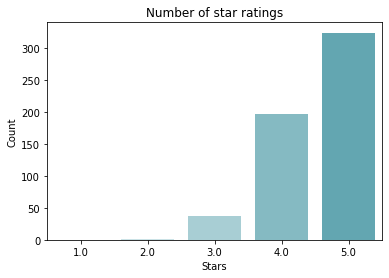

In [38]:
# The distribution of star ratings for this reviewer
pal = sns.light_palette((210, 90, 60), input="husl")
#ax = sns.barplot(x='n', y='stars', data=stars_df, palette=pal, orient='h')
ax = sns.barplot(x='stars', y='n', data=stars_df, palette=pal)
plt.title('Number of star ratings')
plt.ylabel('Count')
plt.xlabel('Stars')

In [39]:
# Where does the review with lowest rating of 2 star come from?
print(cid_reviews[cid_reviews.star_rating == 2.0])

        marketplace  customer_id       review_id  product_id  product_parent  \
5196287          US     50612720  R3W25AC9PE3TZY  B0025TB224       603036081   

                                             product_title product_category  \
5196287  India Ivory Blue Crepe Print Kurta Shirt Kurti...          Apparel   

         star_rating  helpful_votes  total_votes vine verified_purchase  \
5196287          2.0            0.0          2.0    N                 N   

             review_headline  \
5196287  printed crepe Kurti   

                                               review_body review_date  
5196287  Bollywood Style Designer Indian Kurti - Unique...  2009-07-25  


In [40]:
pd.set_option('display.max_colwidth', -1)
print(cid_reviews.loc[cid_reviews.star_rating == 2.0].review_body)

5196287    Bollywood Style Designer Indian Kurti - Unique Indian Kurtis for Women -Summer Dress lucknowi-chikan-- It's the latest in Indian fashion! If you are looking to buy the designer kurtis (tunic) to match with your jeans, trousers or salwars, simply browse this store..............
Name: review_body, dtype: object


This review does not match the 2 star rating. 

In [41]:
# Check out the dates that reviews were posted
dates = dict(cid_reviews['review_date'].value_counts())
dates_df = pd.DataFrame(dates.items(), columns=['review_date', 'n'])
dates_df

,review_date,n
0,2009-07-23,147
1,2009-07-21,132
2,2009-07-25,65
3,2009-07-19,47
4,2009-07-30,29
5,2009-08-10,28
6,2009-08-11,28
7,2009-09-11,28
8,2009-08-31,28
9,2009-08-06,10


In [42]:
# View the last two reviews from customer
print(cid_reviews.loc[cid_reviews.review_date == pd.to_datetime('2009-10-23'), ['star_rating', 'review_body']])

         star_rating  \
5027866  4.0           
5114509  4.0           

                                                                                                                                                                                                                                                                                         review_body  
5027866  Stunning Cotton Kurti with gorgeous colored print. This ethnic kurti is master piece of Indian Ethnic Art.                                                                                                                                                                                   
5114509  Our classic cotton boho tie skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This crinkle skirt offers a bohemian style, tie design, and elastic waistline. Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.  


C:\Users\chant\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Reviews')

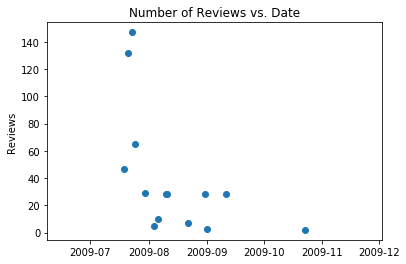

In [43]:
# Plot number of reviews over time
plt.scatter(dates_df.review_date, dates_df.n)
plt.title('Number of Reviews vs. Date')
plt.ylabel('Reviews')

In [44]:
print('Start date:', min(dates_df.review_date))
print('End date:', max(dates_df.review_date))

Start date: 2009-07-19 00:00:00
End date: 2009-10-23 00:00:00


In [45]:
max(dates_df.review_date) - min(dates_df.review_date)

Timedelta('96 days 00:00:00')

In July 21 and 23 of year 2009, there were over 100 reviews posted. Number of reviews decreases drastically throught October 2009. One way to flag suspicious review activity is to identify a maximum limit of reviews written per day for each reviewer. In this case, it would be reasonable to say that writing over 20 reviews is suspicious. We could take into consideration how long the customer has been an active reviewer.

In [46]:
# Check out the products that are reviewed by customer

dict(cid_reviews['product_title'].value_counts()[0:10])

{'White Tunic Yoga Cotton Kurti Clothing of India Casual Summer Dresses Chikan Embroidery Size M': 10,
 'Womens Top Crepe Full Sleeve Kurti/ Blouse/boho/yoga Top L': 10,
 'Womens Kurti Crepe Full Sleeve Top Blouse/boho/yoga Top L': 6,
 'Cotton Long Skirt Summer Spring Fashion Casual Boho Bellydance Indian Clothing': 5,
 'Designer White Cotton Embrdy Kurta Shirt Kurti Blouse L': 5,
 'Cotton Floral Print Tunics Womens Shirts Tops Indian Kurtis Size M': 5,
 'White Tunic Yoga Cotton Kurti Clothing of India Casual Summer Dresses Chikan Embroidery Size L': 5,
 'Designer Ivory Cotton Chikan Embroidery Summer Kurta Tunic Top Yoga Size L': 4,
 'White Cotton Tunic Kurtis Womens Shirts Tops Spring Summer Clothes Hand Embroidery Size M': 4,
 'White Tunic Yoga Cotton Kurti Clothing of India Casual Summer Dresses Chikan Embroidery Size Xl': 4}

This customer reviewed many of the same types of items, and clothing items of various sizes. 

In [47]:
cid_reviews.iloc[0:10].review_body

5027866    Stunning Cotton Kurti with gorgeous colored print. This ethnic kurti is master piece of Indian Ethnic Art.                                                                                                                                                              
5064403    This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This printed skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.
5064413    This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This crinkle skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.
5064414    This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This printed skirt offers a bohemian 

In [48]:
cid_reviews.iloc[500:511].review_body

5196271    This pretty floral print defines your diva status. Allover print tunic with sequence embroidery round neckline, 3/4th sleeves, and designer print in the front and the same design runs straight in both side of the sleeves to give it a finished look.                             
5196272    Stunning Cotton Kurti with gorgeous embroidery. This ethnic embroidery kurti is master piece of Indian Ethnic Art. Must have collection for party wear.                                                                                                                              
5196273    This pretty floral print defines your diva status. Allover print tunic with a solid round neckline, 3/4th sleeves, and designer print in the front and the same design runs straight in both side of the sleeves to give it a finished look.                                         
5196274    Bollywood Style Designer Indian Kurti - Unique Indian Kurtis for Women -Summer Dress lucknowi-chikan-- It's the latest in 

These definitely look like fake/unreliable reviews because of the repeated text for multiple reviews. Extremely large number of similar reviews can be an indicator of unreliable reviews.

In [49]:
customer_df.tail()

,customer_ID,n_reviews
3219078,50755942,1
3219079,13001061,1
3219080,42441050,1
3219081,37968162,1
3219082,29362177,1


In [ ]:
####### NATE: Is there a faster way to to this? 
# Star ratings of 1-review customers (2.2 million)
one_hit_cust = customer_df.customer_ID[customer_df.n_reviews == 1]

start_time = time.time()
one_hit_stars = [url_df[url_df['customer_id']==cid].star_rating.iloc[0] for cid in one_hit_cust]
end_time = time.time()

print(end_time - start_time)

#for cid in set(customer_df.customer_ID[customer_df.n_reviews == 1]):
#    temp = url_df[url_df.customer_id == cid]
#plt.hist(one_hit_stars)
#one_hit_stars.head()


**6.4 hours to run the code above**

In [ ]:
# The number of 
print(len(one_hit_stars))

In [ ]:
Counter(one_hit_stars)

In [ ]:
# Average stars from those who wrote one review
#total/len(one_hit_stars)
print(np.mean(one_hit_stars))

In [ ]:
# Percent of 5-star reviews
print(1190173/2201632)
# Percent of 4-star reviews
print(416831/2201632)

In [ ]:
plt.hist(one_hit_stars, bins=np.arange(1,7)-.5, rwidth=0.5)
plt.title('Star ratings from 1-review customers')
plt.xticks(range(1,6))
plt.xlim([0,6])
plt.xlabel('Star rating')

In [ ]:
# print out the reviews from a sample of 50 customers who have only posted one review
seed(100)
start_time = time.time()
for cid in rsample(set(customer_df.customer_ID[customer_df.n_reviews == 1]), 50):
    temp = url_df[url_df.customer_id == cid]
    print(temp)
    print()
end_time = time.time()
print("time to complete loop:", end_time - start_time)

In [ ]:
# print out the reviews from customers who are not verified, have 0 helpful votes, and have only posted one review
seed(50)
start_time = time.time()
for cid in rsample(set(customer_df.customer_ID[customer_df.n_reviews == 1]), 50):
    condition = (url_df.customer_id == cid) & (url_df['verified_purchase'] == 'N') & (url_df['helpful_votes'] == 0)
    if len(url_df[condition]) != 0:
        temp = url_df[condition]
        #print(temp.star_rating, temp.review_headline, temp.review_body)
        print(temp)
        print()
end_time = time.time()
print("time to complete loop:", end_time - start_time)

In [ ]:
len(url_df)

In [ ]:
# Percent of verified purchases - purchased from Amazon
len(url_df[url_df['verified_purchase'] == 'N']) / len(url_df)